In [7]:
addprocs(2)

2-element Array{Int64,1}:
 2
 3

![Julia logo](./julia.png)
or
# Why should I learn yet another programming language...

Oberseminar

09 June 2016

## Julia: A high-level dynamic programming language designed for high-performance scientific computing

>Julia is a high-level, high-performance dynamic programming language for technical computing, with syntax that is familiar to users of other technical computing environments. It provides a sophisticated compiler, **distributed parallel execution**, numerical accuracy, and an **extensive mathematical function library**. Julia’s Base library, largely written in Julia itself, also integrates mature, best-of-breed open source C and Fortran libraries for **linear algebra**, **random number generation**, **signal processing**, and **string processing**. In addition, the Julia developer community is contributing a number of **external packages** through Julia’s built-in package manager at a rapid pace. **IJulia**, a collaboration between the Jupyter and Julia communities, provides a powerful browser-based graphical notebook interface to Julia.

> [www.julialang.org](http://www.julialang.org)

### Summary of Features
* Multiple dispatch: providing ability to define function behavior across many combinations of argument types
* Dynamic type system: types for documentation, optimization, and dispatch
* Good performance, approaching that of statically-compiled languages like C
* Built-in package manager
* Call C functions directly: no wrappers or special APIs
* Powerful shell-like capabilities for managing other processes
* Designed for parallelism and distributed computation
* User-defined types are as fast and compact as built-ins
* Automatic generation of efficient, specialized code for different argument types
* Elegant and extensible conversions and promotions for numeric and other types
* MIT licensed: free and open source

[www.julialang.org](www.julialang.org)

### Why choose Julia as an alternative to
* Fortran/C/C++
* MATLAB
* Python
* R?

![FORTRAN](fortran_punchcard_s.png)

> I don't know what the language of the year 2000 will look like, but I know it will be called Fortran.
>
> --Tony Hoare, inventor of the Quicksort algorithm, 1980 Turing award recipient

![History](tests.png)

We distinguish **programming languages** like Fortran, C, C++ from **problem solving environments** like MATLAB, Julia, and R.

### What were programming languages developed for?
* Fortran: Technical computing (1950)
* C: Writing operating systems like UNIX (1970)
* Python: System administration (1991)
* MATLAB: Numerical computing in education (1984)
* Julia: Scientific computing (2012)

### Programming languages should be ###
|             | Fortran | C | Python | MATLAB | Julia |
|-------------|:-------:|:-------:|:-------:|:-------:|:-------:|
| Efficient   | x       | x |    o    |   o     |   x   |
| Interactive |         |   |   x    |    x   |   x   |
| Able to run on parallel hardware | x | x |  | o | x |
| Able to call libraries without ceremony | x | x |   |   |  x |
| Open Source | x | x | x |  |  x |
| Open Platform | x | x | x | x | x |

> x: yes, o: yes, but...

### Common practice
* Analyze problem using pen and paper
* Write code in MATLAB
* Test against expected solutions/behaviour
* Use profiler to detect slow parts
* Rewrite slow parts, i.e., make code unreadable
* Rewrite still slow parts in C/Fortran
* Identify opportunities for parallelization

### Problems
* The two-language problem
    * Learning a few languages
    * Interfacing between languages 
* Parallelization
    * Requires more libraries
    * Another level of complexity
    * Learning curve

### Looking for a way out
* Write entire program in Julia
* Profile Julia code
* Optimize Julia code
* Parallelize (still in Julia)
    * Reuse serial code and introduce one programming pattern

### A closer look
* History of Julia
* Two academic examples and one realistic scenario
* Exploring Julia's ecosystem
    * Packages
    * Editors
    * IDE
    * How to avoid the *two language problem*


### Founders of Julia

![Edelman](edelman_s.png)
Alan Edelman, MIT Professor of Applied Mathematics

![](bezanson_s.png)
Jeff Bezanson, PhD


### Founders of Julia

![](karpinski_s.png)
Stefan Karpinski, PhD

![](shaw_s.png)
Viral B. Shaw, PhD

> ...Julia was built on the heels of our parallel computing experience with **Star-P** which began as an MIT research project and was a software product of *Interactive Supercomputing*. Our experience taught us that bolting parallelism onto an existing language that was not designed for performance or parallelism is difficult at best, and impossible at worst. One of our (not so secret) motivations to build Julia was to have the language we wanted for parallel numerical computing.

> A. Edelman, *Julia: A fresh approach to parallel programming*, Parallel and Distributed Processing Symposium (IPDPS), 2015 IEEE International

### History
Julia development started in 2012.

Milestones so far:

* 0.1: 28 Feb 2013
* 0.2: 25 Nov 2013
* 0.3.1: 21 Sep 2014
* ...
* 0.3.7: 23 Mar 2015
* 0.4.1: 08 Nov 2015
* 0.4.5: 18 Mar 2016

Expected is 0.5.0 in July 2016 with **multi-threading support** and a **debugger**.

### Performance as advertized
![](benchmarktable.png)

Actually reproducible!

## Example 1

Consider the expression

$$
    s = \sum\limits_{i=1}^n \frac{i}{2}.
$$

We write two almost identical Julia functions `f1` and `f2` that evaluate $s$ and learn, that **type stability can substantially increase the code efficiency**.

Note: Type declarations are optional in Julia's language description.

In [2]:
function f1(n)
    s = 0
    for i = 1:n
        s += i / 2
    end
    return s
end

f1 (generic function with 1 method)

In [3]:
function f2(n::Int64)
    s = 0.0
    for i = 1:n
        s += i / 2.0
    end
    return s
end

f2 (generic function with 1 method)

This kind of operation is called a *reduction*, since it is generally *tensor-rank-reducing*. A vector of numbers is reduced to a single number, etc.

The signature of the reduction looks like `x = f(x, v[i])`, where `x` is the *accumulator*, `f` is the *reduction function* (in this case `+`), and the `v[i]` are the elements being reduced.

In [4]:
f1(2)
f2(2)

1.5

In [5]:
@time f1(10000000)

  0.250657 seconds (20.00 M allocations: 305.217 MB, 7.57% gc time)


2.50000025e13

In [6]:
@time f2(10000000)

  0.012236 seconds (5 allocations: 176 bytes)


2.50000025e13

#### Summary:
Type declarations (`n::Int64`) and type stable statements (`s = 0.0`) provide the necessary information that the JIT-compiler requires to generate efficient code both in terms of speed and memory requirements.

In the example above, we observe a speedup of about 20 just by introducing type stability!

#### A further note on reductions:

Reductions can be parallelized when the reduction function `f` is associative. This is the case for the addition (`+`).

To demonstrate a simple parallelization on reductions, we inspect Julia's `@parallel` statement.

In [7]:
function f3(n::Int64)
    s::Float64 = @parallel (+) for i = 1:n
        i / 2.0
    end
    return s
end

f3 (generic function with 1 method)

In [8]:
f3(100)

2525.0

In [9]:
@time f3(10000000)

  0.010456 seconds (2.08 k allocations: 156.938 KB)


2.50000025e13

Remark: Parallelization is not effectiv when only a few workers are available.

For reference, the results were obtained with 2 worker processes on a LENOVO ThinkPad T550 notebook with an Intel(R) Core(TM) i5-5200U CPU running at 2.20GHz.

## Example 2

We consider the numerical approximation of $\pi$ using a Monte Carlo method.

Idea: Throwing darts $n$ times into a unit square $[0,1] \times [0,1]$ and count hits only if $\sqrt{x^2 + y^2} < 1$.
To obtain meaningful results, $n$ should be a sufficiently large number.

Note: Counting the hits is a very expensive way of calculating the definite integral

$$
    A = \int_{\varphi = 0}^{\pi/4} \int_{r=0}^1 r\, dr\,d\varphi.
$$

Then, recalling that the area of a unit quarter-circle is $A = \pi/4$, $\pi \approx 4 \frac{n_{inside}}{n}$.

We will implement a sequential and a parallel version. For the latter, we follow the notion of *reduction* and make use of the `@parallel` macro.

In [1]:
function seq_findpi(n::Int64)
    inside = 0
    for i = 1:n
        x, y = rand(2)
        if x^2 + y^2 < 1.0
            inside += 1
        end
    end
    return 4 * inside / n
end

seq_findpi (generic function with 1 method)

In [8]:
function par_findpi(n::Int64)
    inside =  @parallel (+) for i = 1:n
        x, y = rand(2)
        x^2 + y^2 < 1.0 ? 1 : 0
    end
    return 4 * inside / n
end

par_findpi (generic function with 1 method)

In [9]:
seq_findpi(10)
par_findpi(10)

2.8

Execution yields the expected result:

In [12]:
@time seq_findpi(10000000)

  0.838120 seconds (20.00 M allocations: 915.528 MB, 6.21% gc time)


3.1419456

In [11]:
@time par_findpi(10000000)

  0.483638 seconds (3.56 k allocations: 273.672 KB)


3.1421776

On a multi-core CPU using 8 cores, the speedup was 6.7!

## Example 3

As a more realistic example, we consider the problem of non-stationary heat equation in 1-D:

$$
    \partial^2_{xx} u(x, t) - c \partial_t u(x, t) = 0\quad \text{ in }\Omega \in [0, \pi] \times [0, 1]
$$

with boundary conditions

$$
    u(0, t) = u(\pi, t) = 0
$$

and the analytical solution for $c = 1$

$$
    u(x, t) = 3 \exp(-t) \sin(x) -
    \exp(-4t)  \sin(2x) + \exp(-9t)  \sin(3x).
$$

Discretization in space and time: $x \mapsto x_i$, $t \mapsto t^n$, $u \mapsto u^n_i$ yields

$$
    \partial^2_{xx} u \approx \frac{u_{i-1} -2u_i + u_{j+1}}{\Delta x^2}, \quad \partial_t u \approx \frac{u^{n+1} - u^n}{\Delta t}
$$
with $\Delta x$ and $\Delta t$ equidistant steps in space and time, resp.

Discretization of $\partial^2_{xx}$ on equidistant grid yields matrix
$$
    \mathbf A = \frac{1}{\Delta x^2}\begin{bmatrix}
        -2 &  1     & 0      & \dots  & 0 \\
        1  & -2     & 1      & \dots  & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
         0 &  0     & 0      & 1      & -2
    \end{bmatrix}.
$$

After rearranging terms we obtain
$$
    [\mathbf I - \Delta t \mathbf A]u^{n+1} = u^n.
$$

Note that for TEM simulations, $\mathbf A$ and $\mathbf I$ have to be replaced by the discretization of the *curl-curl* operator $\mathbf K$, and the discretization of the electrical conductivity, $\mathbf M$, resp. The initial condition $u^0$ would be represented by the current distribution at $t=0^+$.

In [15]:
dx = pi / 5001.0
x = collect(0.0:dx:pi)
nx = length(x) - 2
A = spdiagm(
    (ones(nx - 1), -2.0*ones(nx), ones(nx - 1)),
    [-1, 0, 1],
    nx, nx)
A = A / (dx * dx)
nx

5000

In [16]:
dt = 1.0e-3
t = collect(0.0:dt:1.0)
nt = length(t) - 1

1000

In [17]:
ana(x, t) = 3.0 * exp(-t) * sin(x) -
    exp(-4.0 * t) * sin(2.0 * x) + exp(-9.0 * t) * sin(3.0 * x)
u0 = ana(x, 0.0);

In [18]:
function implicitEuler(K::AbstractSparseMatrix, M::AbstractSparseMatrix, b::AbstractArray, dt::Float64)
    n = size(K, 1)
    nt = size(b, 2)
    u = zeros(Float64, n, nt)
    rhs = zeros(Float64, n)
    B = cholfact(M + dt * K)
    u[:, 1] = B \ b[:, 1]
    Mu = zeros(Float64, n)
    for j = 2:nt
        Base.A_mul_B!(Mu, M, u[:, j-1])
        rhs = b[:, j] + Mu
        u[:, j] = B \ rhs
    end
    return u
end

implicitEuler (generic function with 1 method)

In [19]:
u = zeros(eltype(u0), nx, nt)
u[:, 1] = u0[2:end-1]
@time uu = implicitEuler(-A, speye(nx), u, dt);

  0.675866 seconds (590.56 k allocations: 447.548 MB, 9.23% gc time)


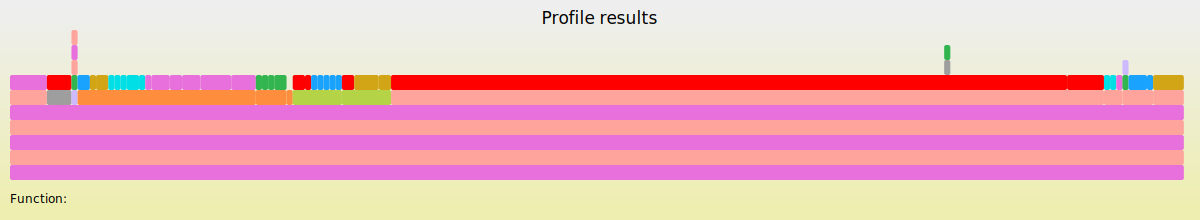

In [20]:
using ProfileView

Profile.clear()
@profile uu = implicitEuler(-A, speye(nx), u, dt)
ProfileView.view()

## Julia's Ecosystem

### Packages (June 2016)

![pulse](allver.png)

### Installing Julia

Go to [julialang.org](www.julialang.org) and choose the appropriate installer.

### Running Julia

* In the terminal using the built-in command line
* In the Juno IDE
* In the browser with Jupyter notebooks.

### Julia in the terminal

REPL: **R**ead-**E**valuate-**P**rint **L**oop

![REPL](REPL.png)

### Calling Julia on HPC

`$ julia -p 512 extremely_large_numerical_problem.jl`

starts Julia on 512 processors in a non-interactive mode.

### Running Julia in the Juno IDE

Juno is built on the highly customizable editor [Atom](http://www.atom.io).

1. Install Atom
2. Within Atom, go to Settings and install package `uber-juno`

![](atom.png)

### Jupyter notebooks

Interactive "narrative" environment running in the browser.

Setup is easy:

1. Install Python (Anaconda is highly recommended https://www.continuum.io/downloads)
2. In Julia, add package "IJulia"

In [21]:
Pkg.add("IJulia")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of IJulia
INFO: Use `Pkg.update()` to get the latest versions of your packages


### Jupyter notebooks

![Jupyter](jupyter.png)

In a terminal, start a jupyter session:

![](jupyter-in-terminal.png)

### Migration from MATLAB to Julia

Arrays: x(1) in MATLAB becomes x[1] in Julia. Arrays are passed by reference. A=B is dangerous!

Successfully ported:
* Nedelec.jl: Nédélec Finite Elements (forked from J. Weißflogs MATLAB implementation)
* SparseTensors.jl: Sparse 3-way-tensor extensively used in our EM inversion schemes
* TetrahedralMeshes.jl: Working with tetrahedral meshes generated by the TetGen library
* EulerMethod.jl: Euler method for time integration of ODE's

### Other geophysics-related Julia packages

* Seismic.jl: SeismicJulia package developed at U of Alberta, Canada
* jInv.jl: Flexible Framework for Parallel PDE Parameter Estimation in Julia, U of British Columbia, Vancouver, Canada (E. Haber, L. Ruthotto)

# Why not make your next language Julia?
## It might even be the last one you need to learn...
![](julia.png)

www.julialang.org

www.atom.io

www.continuum.io/downloads